<a href="https://colab.research.google.com/github/m677s345/EECS_731_MS_Project_6/blob/main/EECS_731_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cookiecutter
!cookiecutter https://github.com/drivendata/cookiecutter-data-science

     |████████████████████████████████| 51kB 2.9MB/s 
project_name [project_name]: 
repo_name [project_name]: 
author_name [Your name (or your organization/company/team)]: 
description [A short description of the project.]: 
Select open_source_license:
1 - MIT
2 - BSD-3-Clause
3 - No license file
Choose from 1, 2, 3 [1]: 
s3_bucket [[OPTIONAL] your-bucket-for-syncing-data (do not include 's3://')]: 
aws_profile [default]: 
Select python_interpreter:
1 - python3
2 - python
Choose from 1, 2 [1]: 



In [14]:
# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np
from sklearn import svm
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [4]:
df = pd.read_csv("/content/project_name/data/raw/ambient_temperature_system_failure.csv")

# Data Visualization and Feature Engineering

Just doing some statistcis on the data we can see that for the most part the temperature stays within 4 degrees of the average. The max and min are definatly going to be anomilies to look for in the anomally detection.

In [5]:
print(df.info())
print(df.describe())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None
             value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


It will be useful to change the timestamp to a date time datatype so we can use some of the unique features pandas has regaurding them. Once the data is plottes we can see that there are some fairly regular trends. IE the office is warmer in the winter where it is probobly colder outside and cooler in the summer months but there are some outliers.

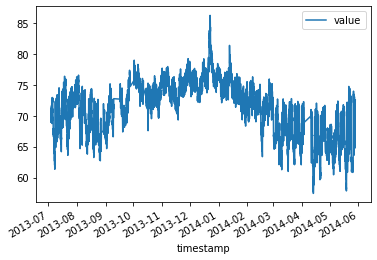

In [6]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# plot the data
df.plot(x='timestamp', y='value')

The first feature engineered is going to be defining the daylight hours. Most likely there is less of a chance to have a temperature anommaly when there are employees present. I assumed that the day ran from 7:00am to 9:00pm that is about average ofer a year here in the midwest. I assumed that the seasonal daylight changes are less of an effect on the temperature than the effect of vairable temperature outside.  

In [7]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 8) & (df['hours'] <= 22)).astype(int)

I also split the week up into work days and week days. Using this information I am operating on the assumption that there are less people working on the weekends 

In [30]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['Workdays'] = df['timestamp'].dt.dayofweek
df['Weekday'] = (df['Workdays'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [31]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

Here we create 4 categories. Day and night combinations of weekdays and weekends. The idea here is it will be easier to see the temperature fluctuations for each of these features individually. 

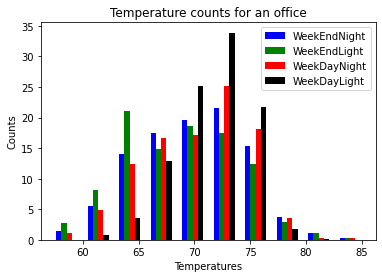

In [32]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['Weekday']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')
# Add title and axis names
plt.title('Temperature counts for an office')
plt.xlabel('Temperatures')
plt.ylabel('Counts')

plt.legend()
plt.show()

In the above figure we can see that the highest counts for temperatures around the mean are during the weekday in the daylight hours and night hours. The hugh count of weekend light having a low temperature value is interesting and may be a trend showing that there are cooler working conditions on the weekend. 

# Isolation Forest

We will begin assembling the methods for our annomally detection. The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies. Enabling us to detect the anomalies and flag them as such.

In [33]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'Workdays', 'Weekday']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly'] = pd.Series(model.predict(data))
df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )
print(df['anomaly'].value_counts())

0    7194
1      73
Name: anomaly, dtype: int64


Below is a plot of the data vs time and we can see that the isolation forest did a good job at determining the highest and lowest fluctuations in the data. However maybe I chose too high of a percentage of outliers because there is a fair amount of points classified anomalied within a standard dievation of the mean. 

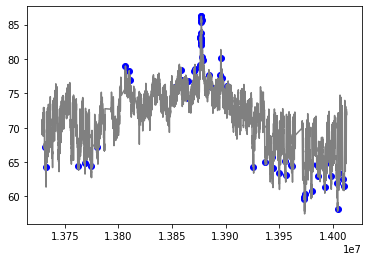

In [34]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='grey')
ax.scatter(a['time_epoch'],a['value'], color='blue')
plt.show()

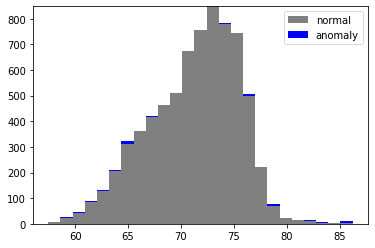

In [37]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly'] == 0, 'value']
b = df.loc[df['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=25, stacked=True, color=['grey', 'blue'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

In the code below we explore normilizing the temperature with the average temperature with the idea that larger deviations will have larger/smaller values allowing for easier detection by the random forest.

In [71]:
df['norm_T']=(df['value']/(df['value'].mean()))**2

In [72]:
# Take useful feature and standardize them 
data = df[['norm_T', 'hours', 'daylight', 'Workdays', 'Weekday']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly2'] = pd.Series(model.predict(data))
df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )
print(df['anomaly2'].value_counts())

0    7194
1      73
Name: anomaly2, dtype: int64


There are some slight changes in the detection of anomalies we get some data closer to the tips of the outliers. The main difference is the presance of more outliers on the tips of the points. I think that creating a normalized temperature showed all the data points associated with an anomaly; this could be useful as a shutdown condition.

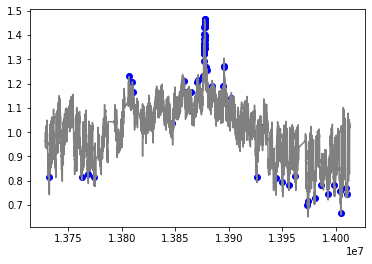

In [73]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly2'] == 1, ['time_epoch', 'norm_T']] #anomaly

ax.plot(df['time_epoch'], df['norm_T'], color='grey')
ax.scatter(a['time_epoch'],a['norm_T'], color='blue')
plt.show()

# One Class SVM

The next method is one class SVM. A One-Class Support Vector Machine is an unsupervised learning algorithm that is trained only on the ‘normal’ data. It learns the boundaries of these points and is therefore able to classify any points that lie outside the boundary as an outlier. We can use this to determine the temperatures that are seperate from our normal data.

In [96]:
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    7198
1      69
Name: anomaly26, dtype: int64


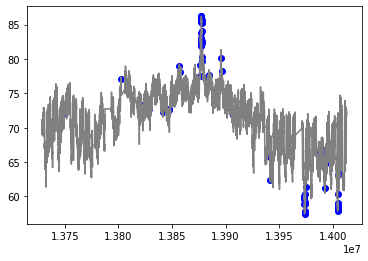

In [97]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='grey')
ax.scatter(a['time_epoch'],a['value'], color='blue')
plt.show()

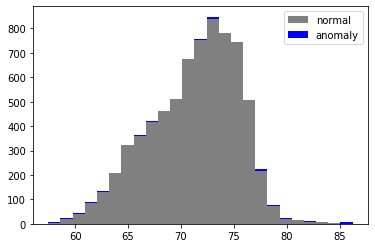

In [84]:
#visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=25, stacked=True, color=['grey', 'blue'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Overall the SVM didn't do as good of a job detecting outliers as the isolation forest did. This coulb be that the outlier data is too close to the normal data. We might need to magnify the chance of something beign an outlier or potentally have more data to have this work better. The nu value can be tweaked to find the optimum for detecting the specific outliers. Overall both of these methods were able to detect the major high temperature and low temperature variations so I am happy with the result. More feature engineerign on the normalized temperature could lead to even higher accuracy of the anomaly detection.